In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and standardize result files
rf = pd.read_csv("02_complex_baselines/results/rf/10_fold_voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]
xgb = pd.read_csv("02_complex_baselines/results/xgboost/10_fold_voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]
enet = pd.read_csv("01_simple_baselines/results/elastic_net/10_fold_voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]

# Rename columns for clarity
rf = rf.rename(columns={
    "r2_global": "R2_RF",
    "pearson_r": "Pearson_RF",
    "rmse": "RMSE_RF"
})

xgb = xgb.rename(columns={
    "r2_global": "R2_XGB",
    "pearson_r": "Pearson_XGB",
    "rmse": "RMSE_XGB"
})

enet = enet.rename(columns={
    "r2_global": "R2_EN",
    "pearson_r": "Pearson_EN",
    "rmse": "RMSE_EN"
})

# Merge all on DRUG_ID
merged = rf.merge(xgb, on="DRUG_ID").merge(enet, on="DRUG_ID")
print("RF total drugs:", len(rf))
print("XGB total drugs:", len(xgb))
print("EN total drugs:", len(enet))
print("Drugs after merging:", len(merged))

# Show mean performance across drugs
print("📊 Mean Performance per Model:")
for metric in ["R2", "Pearson", "RMSE"]:
    print(f"\n{metric}:")
    print(merged[[f"{metric}_RF", f"{metric}_XGB", f"{metric}_EN"]].mean().sort_values(ascending=False))


RF total drugs: 692
XGB total drugs: 692
EN total drugs: 692
Drugs after merging: 692
📊 Mean Performance per Model:

R2:
R2_EN     0.240014
R2_RF     0.226726
R2_XGB    0.223722
dtype: float64

Pearson:
Pearson_EN     0.475952
Pearson_RF     0.466315
Pearson_XGB    0.464493
dtype: float64

RMSE:
RMSE_XGB    1.171472
RMSE_RF     1.169821
RMSE_EN     1.161208
dtype: float64


/tmp/ipykernel_1448970/3065410326.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


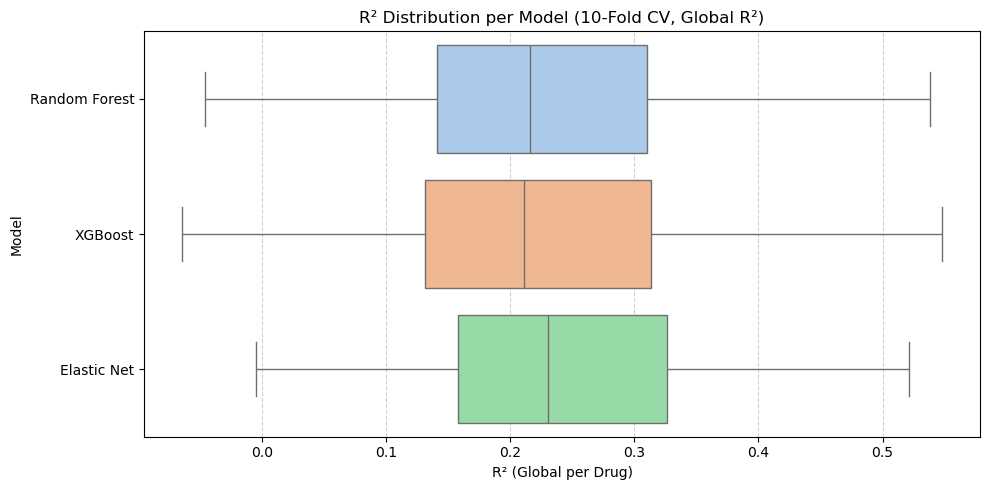

📊 Mean R² per model:
R2_EN     0.240014
R2_RF     0.226726
R2_XGB    0.223722
dtype: float64

📈 Elastic Net vs. RF
Improved drugs: 502
Worsened drugs: 190
Mean ΔR²: 0.0133

📈 Elastic Net vs. XGB
Improved drugs: 527
Worsened drugs: 165
Mean ΔR²: 0.0163

📈 XGB vs. RF
Improved drugs: 323
Worsened drugs: 369
Mean ΔR²: -0.0030


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and standardize result files
rf = pd.read_csv("02_complex_baselines/results/rf/10_fold_voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]
xgb = pd.read_csv("02_complex_baselines/results/xgboost/10_fold_voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]
enet = pd.read_csv("01_simple_baselines/results/elastic_net/10_fold_voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]

# Rename for clarity
rf = rf.rename(columns={"r2_global": "R2_RF", "pearson_r": "Pearson_RF", "rmse": "RMSE_RF"})
xgb = xgb.rename(columns={"r2_global": "R2_XGB", "pearson_r": "Pearson_XGB", "rmse": "RMSE_XGB"})
enet = enet.rename(columns={"r2_global": "R2_EN", "pearson_r": "Pearson_EN", "rmse": "RMSE_EN"})

# Merge all on DRUG_ID
merged = rf.merge(xgb, on="DRUG_ID").merge(enet, on="DRUG_ID")

# Prepare long-format DataFrame for boxplot
long_r2 = merged[["DRUG_ID", "R2_RF", "R2_XGB", "R2_EN"]].melt(
    id_vars="DRUG_ID",
    value_vars=["R2_RF", "R2_XGB", "R2_EN"],
    var_name="Model",
    value_name="R2"
)

# Rename model names for cleaner labels
long_r2["Model"] = long_r2["Model"].replace({
    "R2_RF": "Random Forest",
    "R2_XGB": "XGBoost",
    "R2_EN": "Elastic Net"
})

# Plot R² distributions
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=long_r2,
    x="R2",
    y="Model",
    palette="pastel",
    showfliers=False
)
plt.title("R² Distribution per Model (10-Fold CV, Global R²)")
plt.xlabel("R² (Global per Drug)")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Mean R² per model
mean_r2 = merged[["R2_RF", "R2_XGB", "R2_EN"]].mean()
print("📊 Mean R² per model:")
print(mean_r2.sort_values(ascending=False))

# Pairwise ΔR² comparisons
merged["Δ_EN_vs_RF"] = merged["R2_EN"] - merged["R2_RF"]
merged["Δ_EN_vs_XGB"] = merged["R2_EN"] - merged["R2_XGB"]
merged["Δ_XGB_vs_RF"] = merged["R2_XGB"] - merged["R2_RF"]

# Print summary
for label, delta_col in {
    "Elastic Net vs. RF": "Δ_EN_vs_RF",
    "Elastic Net vs. XGB": "Δ_EN_vs_XGB",
    "XGB vs. RF": "Δ_XGB_vs_RF"
}.items():
    print(f"\n📈 {label}")
    print(f"Improved drugs: {(merged[delta_col] > 0).sum()}")
    print(f"Worsened drugs: {(merged[delta_col] < 0).sum()}")
    print(f"Mean ΔR²: {merged[delta_col].mean():.4f}")


In [11]:
from scipy.stats import ttest_rel

# Perform paired t-tests across metrics
for metric in ["R2", "Pearson", "RMSE"]:
    print(f"\n📊 Paired t-tests for {metric}:")

    # Prepare values
    col_en = f"{metric}_EN"
    col_rf = f"{metric}_RF"
    col_xgb = f"{metric}_XGB"

    # Invert RMSE so that higher = better
    if metric == "RMSE":
        merged[col_en] = -merged[col_en]
        merged[col_rf] = -merged[col_rf]
        merged[col_xgb] = -merged[col_xgb]

    # EN vs RF
    t_stat, p_val = ttest_rel(merged[col_en], merged[col_rf])
    print(f"Elastic Net vs. RF: t = {t_stat:.3f}, p = {p_val:.3e}")

    # EN vs XGB
    t_stat, p_val = ttest_rel(merged[col_en], merged[col_xgb])
    print(f"Elastic Net vs. XGBoost: t = {t_stat:.3f}, p = {p_val:.3e}")

    # XGB vs RF
    t_stat, p_val = ttest_rel(merged[col_xgb], merged[col_rf])
    print(f"XGBoost vs. RF: t = {t_stat:.3f}, p = {p_val:.3e}")



📊 Paired t-tests for R2:
Elastic Net vs. RF: t = 12.337, p = 9.627e-32
Elastic Net vs. XGBoost: t = 14.277, p = 1.031e-40
XGBoost vs. RF: t = -4.561, p = 6.016e-06

📊 Paired t-tests for Pearson:
Elastic Net vs. RF: t = 8.685, p = 2.720e-17
Elastic Net vs. XGBoost: t = 10.183, p = 8.742e-23
XGBoost vs. RF: t = -3.030, p = 2.538e-03

📊 Paired t-tests for RMSE:
Elastic Net vs. RF: t = 9.813, p = 2.290e-21
Elastic Net vs. XGBoost: t = 10.687, p = 8.890e-25
XGBoost vs. RF: t = -3.135, p = 1.793e-03
